# Light Frame Calibration Workshop

This notebook explores the calibration process step-by-step using AB Aur images.

We'll load light frames, bias, dark, and flat frames, then manually perform calibration to understand what's happening.

In [11]:
# Import required libraries
import sys
sys.path.insert(0, 'src')

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astrofiler.models import fitsFile, fitsSession, Masters

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 10)
%matplotlib inline

## Find AB Aur Images

Let's query the database to find AB Aur light frames and their associated calibration frames.

Searching for AB Aur light frames...
Found 24 AB Aur light frames

Displaying first light frame of AB Aur: K:/00 REPOSITORY/Light/AB Aur/Celestron_C8_2032@F_10.0/ZWO_CCD_ASI183MM_Pro/20240226/AB Aur-Celestron_C8_2032@F_10.0-ZWO_CCD_ASI183MM_Pro-B-20240226015756-30.0s-1x1-t-25.0.fits


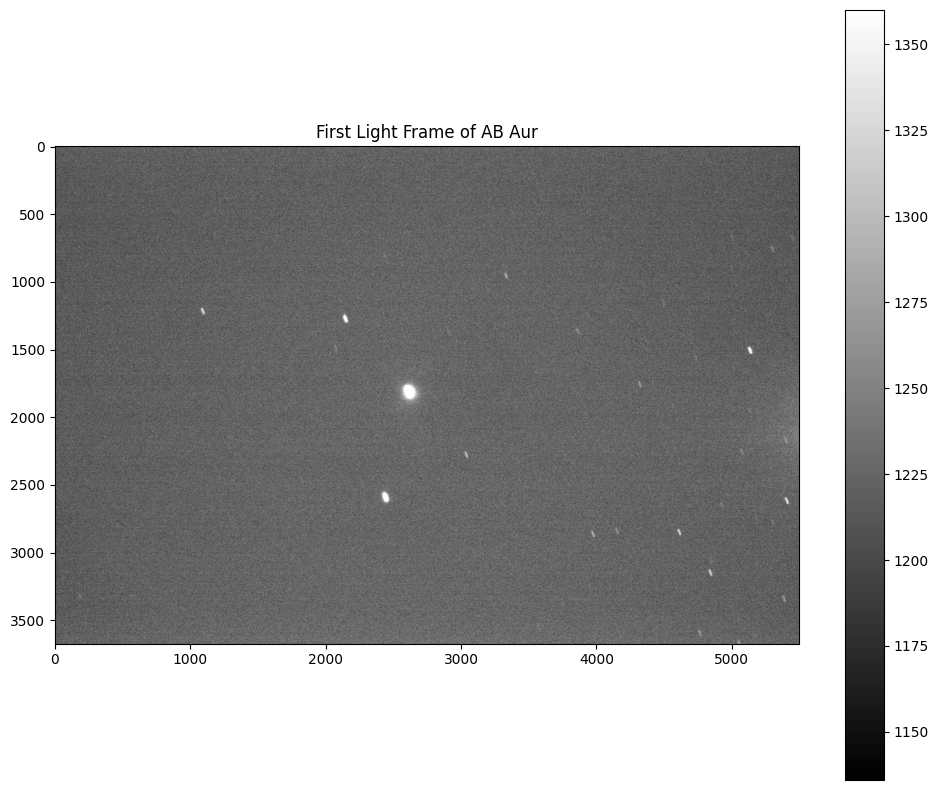

In [12]:
# Search for AB Aur light frames
print("Searching for AB Aur light frames...")
ab_aur_lights = fitsFile.select().where(fitsFile.fitsFileObject == 'AB Aur')
print(f"Found {ab_aur_lights.count()} AB Aur light frames")

if ab_aur_lights.count() == 0:
    print("\nNo AB Aur frames found. Trying alternative names...")
    # Try variations
    ab_aur_lights = fitsFile.select().where(fitsFile.fitsFileObject.contains('AB'))
    print(f"Found {ab_aur_lights.count()} frames containing 'AB'")
    
    # Show what objects we have
    objects = set()
    for light in fitsFile.select().limit(1000):
        if light.fitsFileObject:
            objects.add(light.fitsFileObject)
    print(f"\nAvailable objects (sample): {sorted(list(objects)[:20])}")
else:
    # Visualize first light frame of AB Aur
    first_light = ab_aur_lights[0]
    print(f"\nDisplaying first light frame of AB Aur: {first_light.fitsFileName}")
    first_light_data = fits.getdata(first_light.fitsFileName)
    plt.imshow(first_light_data, cmap='gray', vmin=np.percentile(first_light_data, 5), vmax=np.percentile(first_light_data, 99))
    plt.colorbar()
    plt.title('First Light Frame of AB Aur')
    plt.show()

## Find Matching Calibration Frames

Find the bias, dark, and flat masters that were used for this session.

In [13]:
# Get session info and light frame metadata
session_id = first_light.fitsFileSession

# Need to load light frame data and header first
with fits.open(first_light.fitsFileName) as hdul:
    light_data = hdul[0].data.astype(np.float64)
    light_header = hdul[0].header

# Get the binning and dimensions from the light frame
print(f"Light frame session: {session_id}")
print(f"Light frame binning: {light_header.get('XBINNING', 1)}x{light_header.get('YBINNING', 1)}")
print(f"Light frame shape: {light_data.shape}")
print(f"Light frame camera: {light_header.get('INSTRUME', 'Unknown')}")
print(f"Light frame telescope: {light_header.get('TELESCOP', 'Unknown')}")

# Find masters that match the light frame characteristics
light_binning_x = str(light_header.get('XBINNING', 1))
light_binning_y = str(light_header.get('YBINNING', 1))
light_camera = light_header.get('INSTRUME', '')
light_telescope = light_header.get('TELESCOP', '')

print(f"\nSearching for masters with binning {light_binning_x}x{light_binning_y}, camera: {light_camera}")

# Find matching bias master
bias_master = (Masters.select()
               .where(
                   (Masters.master_type == 'bias') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

# Find matching dark master  
dark_master = (Masters.select()
               .where(
                   (Masters.master_type == 'dark') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

# Find matching flat master
flat_master = (Masters.select()
               .where(
                   (Masters.master_type == 'flat') &
                   (Masters.binning_x == light_binning_x) &
                   (Masters.binning_y == light_binning_y) &
                   (Masters.instrument == light_camera)
               )
               .order_by(Masters.creation_date.desc())
               .first())

print(f"\nBias Master: {bias_master.master_path if bias_master else 'Not found'}")
if bias_master:
    print(f"  Binning: {bias_master.binning_x}x{bias_master.binning_y}, Created: {bias_master.creation_date}")
    
print(f"Dark Master: {dark_master.master_path if dark_master else 'Not found'}")
if dark_master:
    print(f"  Binning: {dark_master.binning_x}x{dark_master.binning_y}, Created: {dark_master.creation_date}")
    
print(f"Flat Master: {flat_master.master_path if flat_master else 'Not found'}")
if flat_master:
    print(f"  Binning: {flat_master.binning_x}x{flat_master.binning_y}, Created: {flat_master.creation_date}")

Light frame session: be77c09d-c16f-45ec-b9f1-8e093f9c6ba6
Light frame binning: 1x1
Light frame shape: (3672, 5496)
Light frame camera: ZWO CCD ASI183MM Pro
Light frame telescope: Celestron C8 2032@F\10.0

Searching for masters with binning 1x1, camera: ZWO CCD ASI183MM Pro

Bias Master: K:/00 REPOSITORY/Masters\Master-Bias-EQMod_Mount-ZWO_CCD_ASI183MM_Pro-20231020-3.2e-05s-1x1-t-25.0.fits
  Binning: 1x1, Created: 2025-11-15 14:19:39.995415
Dark Master: K:/00 REPOSITORY/Masters\Master-Dark-Celestron_C8_2032_F_10.0-ZWO_CCD_ASI183MM_Pro-20231228-30.0s-1x1-t-25.0.fits
  Binning: 1x1, Created: 2025-11-15 14:22:05.024849
Flat Master: K:/00 REPOSITORY/Masters\Master-Flat-Celestron_C8_2032_F_10.0-ZWO_CCD_ASI183MM_Pro-Red-20231227-0.1440511s-1x1-t-25.0.fits
  Binning: 1x1, Created: 2025-11-15 13:49:32.122140


## Load the Image Data

Load all frames into memory and examine their properties.

In [14]:
# Load light frame (already loaded above, but let's verify)
print(f"Light Frame Shape: {light_data.shape}")
print(f"Light Frame dtype: {light_data.dtype}")
print(f"Light Frame - Min: {np.min(light_data)}, Max: {np.max(light_data)}")
print(f"Light Frame - Mean: {np.mean(light_data):.1f}, Median: {np.median(light_data):.1f}")
print(f"Exposure Time: {light_header.get('EXPTIME', 'N/A')}s")

# Load bias and check dimensions
if bias_master:
    with fits.open(bias_master.master_path) as hdul:
        bias_data = hdul[0].data.astype(np.float64)
        
    print(f"\nBias Frame Shape: {bias_data.shape}")
    print(f"Bias Frame - Min: {np.min(bias_data)}, Max: {np.max(bias_data)}")
    print(f"Bias Frame - Mean: {np.mean(bias_data):.1f}, Median: {np.median(bias_data):.1f}")
    
    if bias_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Bias shape {bias_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No bias master found!")
    bias_data = None

# Load dark and check dimensions
if dark_master:
    with fits.open(dark_master.master_path) as hdul:
        dark_data = hdul[0].data.astype(np.float64)
        dark_header = hdul[0].header
        
    print(f"\nDark Frame Shape: {dark_data.shape}")
    print(f"Dark Frame - Min: {np.min(dark_data)}, Max: {np.max(dark_data)}")
    print(f"Dark Frame - Mean: {np.mean(dark_data):.1f}, Median: {np.median(dark_data):.1f}")
    print(f"Dark Exposure Time: {dark_header.get('EXPTIME', 'N/A')}s")
    
    if dark_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Dark shape {dark_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No dark master found!")
    dark_data = None

# Load flat and check dimensions
if flat_master:
    with fits.open(flat_master.master_path) as hdul:
        flat_data = hdul[0].data.astype(np.float64)
        
    print(f"\nFlat Frame Shape: {flat_data.shape}")
    print(f"Flat Frame - Min: {np.min(flat_data):.1f}, Max: {np.max(flat_data):.1f}")
    print(f"Flat Frame - Mean: {np.mean(flat_data):.1f}, Median: {np.median(flat_data):.1f}")
    
    if flat_data.shape != light_data.shape:
        print(f"  ⚠️ WARNING: Flat shape {flat_data.shape} doesn't match light {light_data.shape}")
else:
    print("\n⚠️ No flat master found!")
    flat_data = None

# Summary
print("\n" + "="*60)
if all([bias_data is not None, dark_data is not None, flat_data is not None]):
    if all([bias_data.shape == light_data.shape, 
            dark_data.shape == light_data.shape,
            flat_data.shape == light_data.shape]):
        print("✅ All calibration frames loaded and dimensions match!")
    else:
        print("❌ Dimension mismatch detected - calibration will fail!")
else:
    print("❌ Some calibration frames are missing!")

Light Frame Shape: (3672, 5496)
Light Frame dtype: float64
Light Frame - Min: 432.0, Max: 65504.0
Light Frame - Mean: 1224.8, Median: 1216.0
Exposure Time: 30.0s

Bias Frame Shape: (3672, 5496)
Bias Frame - Min: 1013.0, Max: 1254.0
Light Frame - Mean: 1224.8, Median: 1216.0
Exposure Time: 30.0s

Bias Frame Shape: (3672, 5496)
Bias Frame - Min: 1013.0, Max: 1254.0
Bias Frame - Mean: 1094.2, Median: 1094.0

Dark Frame Shape: (3672, 5496)
Dark Frame - Min: 824.0, Max: 36298.0
Bias Frame - Mean: 1094.2, Median: 1094.0

Dark Frame Shape: (3672, 5496)
Dark Frame - Min: 824.0, Max: 36298.0
Dark Frame - Mean: 1350.9, Median: 1350.0
Dark Exposure Time: 30.0s

Flat Frame Shape: (3672, 5496)
Flat Frame - Min: 6316.0, Max: 8248.0
Dark Frame - Mean: 1350.9, Median: 1350.0
Dark Exposure Time: 30.0s

Flat Frame Shape: (3672, 5496)
Flat Frame - Min: 6316.0, Max: 8248.0
Flat Frame - Mean: 7567.1, Median: 7580.0

✅ All calibration frames loaded and dimensions match!
Flat Frame - Mean: 7567.1, Median: 75

## Visualize Raw Images

Let's look at the raw light frame and calibration frames.

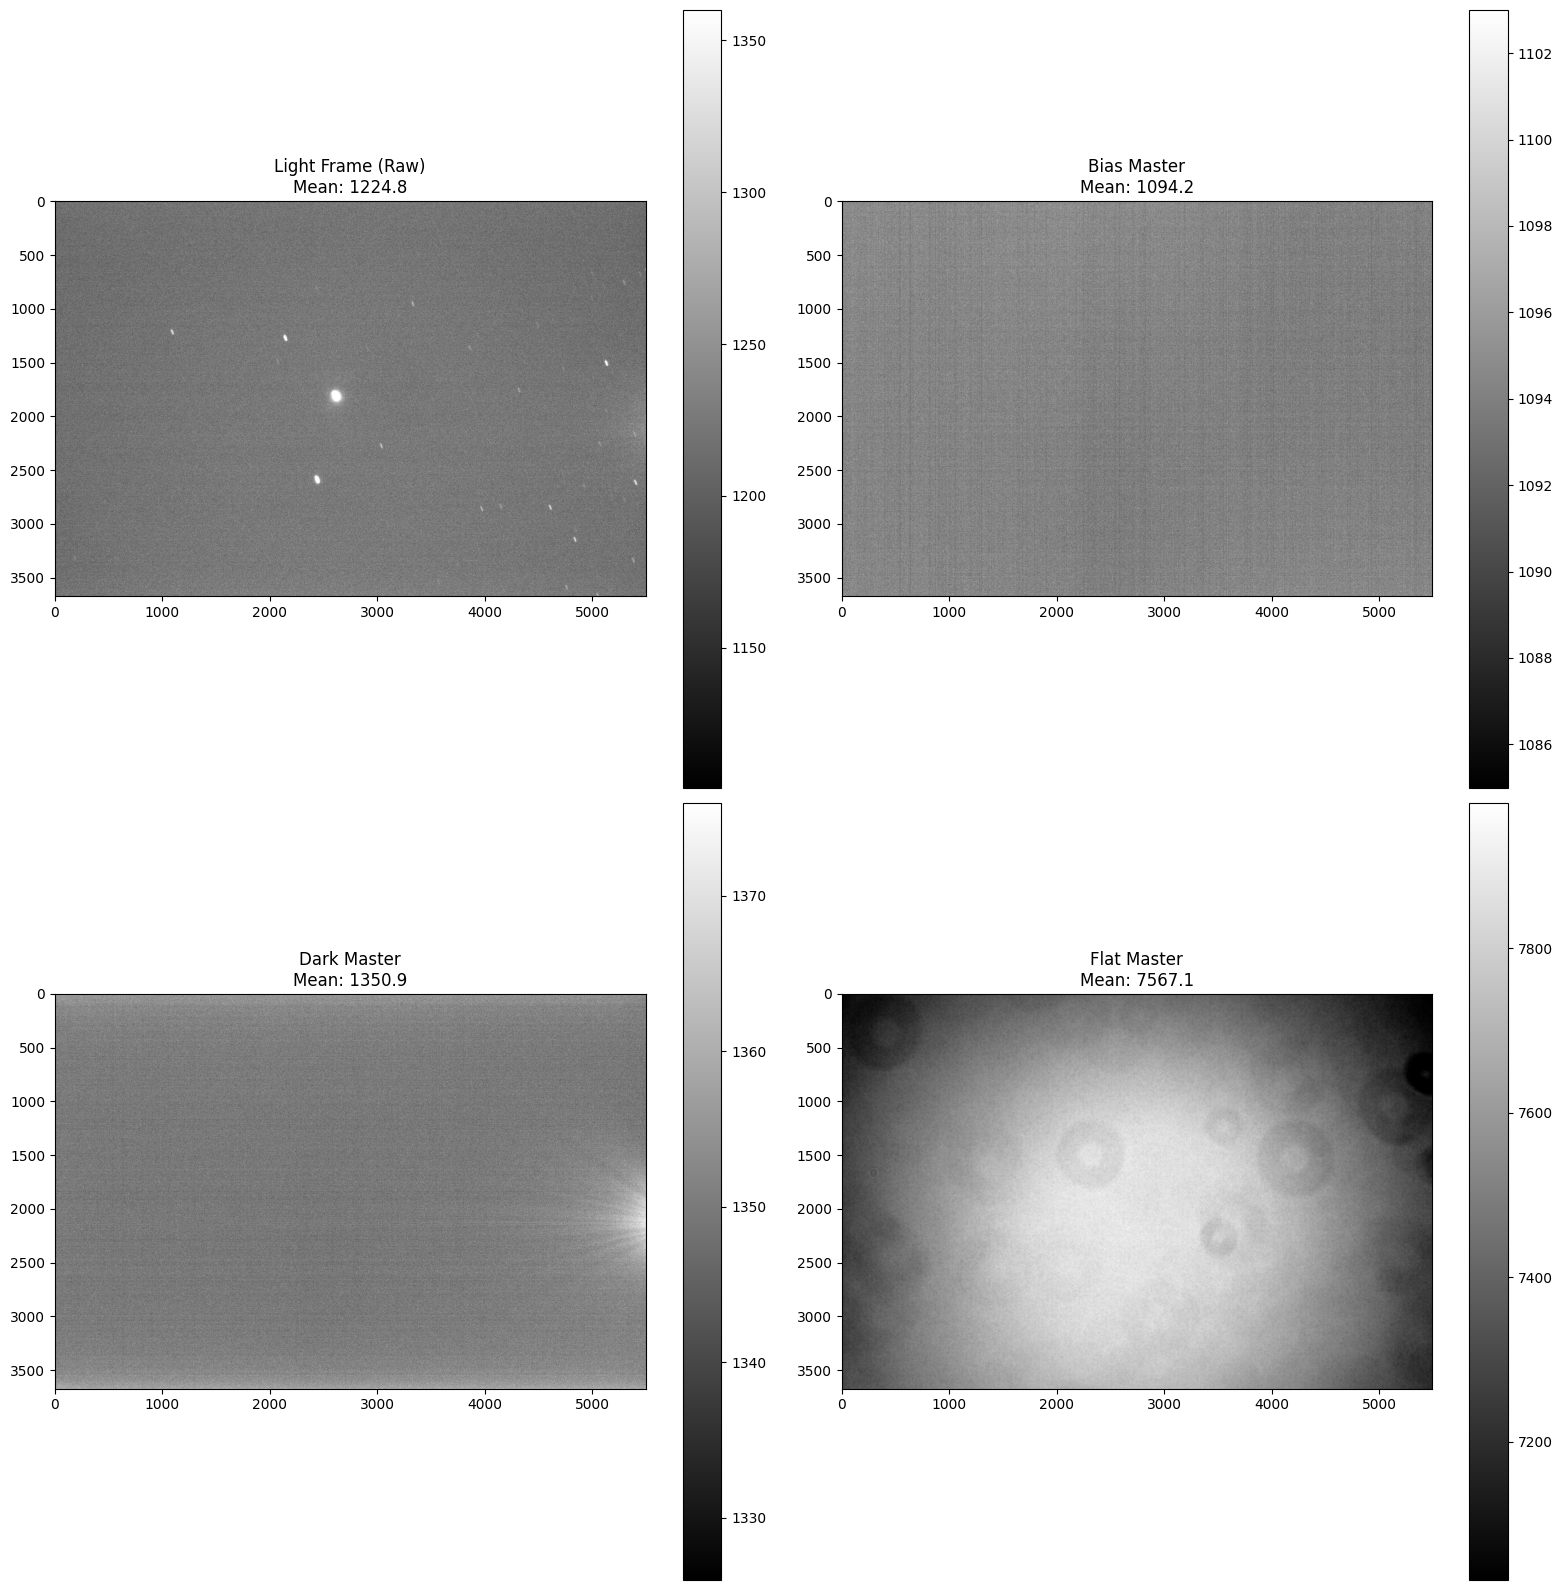

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot light frame
im0 = axes[0, 0].imshow(light_data, cmap='gray', vmin=np.percentile(light_data, 1), 
                         vmax=np.percentile(light_data, 99))
axes[0, 0].set_title(f'Light Frame (Raw)\nMean: {np.mean(light_data):.1f}')
plt.colorbar(im0, ax=axes[0, 0])

# Plot bias
im1 = axes[0, 1].imshow(bias_data, cmap='gray', vmin=np.percentile(bias_data, 1), 
                         vmax=np.percentile(bias_data, 99))
axes[0, 1].set_title(f'Bias Master\nMean: {np.mean(bias_data):.1f}')
plt.colorbar(im1, ax=axes[0, 1])

# Plot dark
im2 = axes[1, 0].imshow(dark_data, cmap='gray', vmin=np.percentile(dark_data, 1), 
                         vmax=np.percentile(dark_data, 99))
axes[1, 0].set_title(f'Dark Master\nMean: {np.mean(dark_data):.1f}')
plt.colorbar(im2, ax=axes[1, 0])

# Plot flat
im3 = axes[1, 1].imshow(flat_data, cmap='gray', vmin=np.percentile(flat_data, 1), 
                         vmax=np.percentile(flat_data, 99))
axes[1, 1].set_title(f'Flat Master\nMean: {np.mean(flat_data):.1f}')
plt.colorbar(im3, ax=axes[1, 1])

plt.tight_layout()
plt.show()

## Step-by-Step Calibration

Now let's perform calibration step by step and examine what happens at each stage.

In [16]:
# Step 1: Subtract Dark (which includes bias)
step1 = light_data - dark_data

print("After Dark Subtraction:")
print(f"  Min: {np.min(step1):.1f}, Max: {np.max(step1):.1f}")
print(f"  Mean: {np.mean(step1):.1f}, Median: {np.median(step1):.1f}")
print(f"  5th percentile (background): {np.percentile(step1, 5):.1f}")
print(f"  95th percentile (bright): {np.percentile(step1, 95):.1f}")

# Step 2: Normalize flat
flat_median = np.median(flat_data)
flat_normalized = flat_data / flat_median
print(f"\nFlat normalized by median: {flat_median:.1f}")
print(f"  Normalized flat range: [{np.min(flat_normalized):.3f}, {np.max(flat_normalized):.3f}]")

# Step 3: Divide by flat
step2 = step1 / flat_normalized

print("\nAfter Flat Division:")
print(f"  Min: {np.min(step2):.1f}, Max: {np.max(step2):.1f}")
print(f"  Mean: {np.mean(step2):.1f}, Median: {np.median(step2):.1f}")
print(f"  5th percentile (background): {np.percentile(step2, 5):.1f}")
print(f"  95th percentile (bright): {np.percentile(step2, 95):.1f}")

calibrated = step2

After Dark Subtraction:
  Min: -2768.0, Max: 64174.0
  Mean: -126.1, Median: -130.0
  5th percentile (background): -221.0
  Mean: -126.1, Median: -130.0
  5th percentile (background): -221.0
  95th percentile (bright): -32.0
  95th percentile (bright): -32.0

Flat normalized by median: 7580.0
  Normalized flat range: [0.833, 1.088]

After Flat Division:
  Min: -2648.1, Max: 63086.4

Flat normalized by median: 7580.0
  Normalized flat range: [0.833, 1.088]

After Flat Division:
  Min: -2648.1, Max: 63086.4
  Mean: -126.7, Median: -130.6
  5th percentile (background): -222.2
  Mean: -126.7, Median: -130.6
  5th percentile (background): -222.2
  95th percentile (bright): -31.5
  95th percentile (bright): -31.5


## Compare Original vs Calibrated

Visualize the results to see if calibration worked correctly.

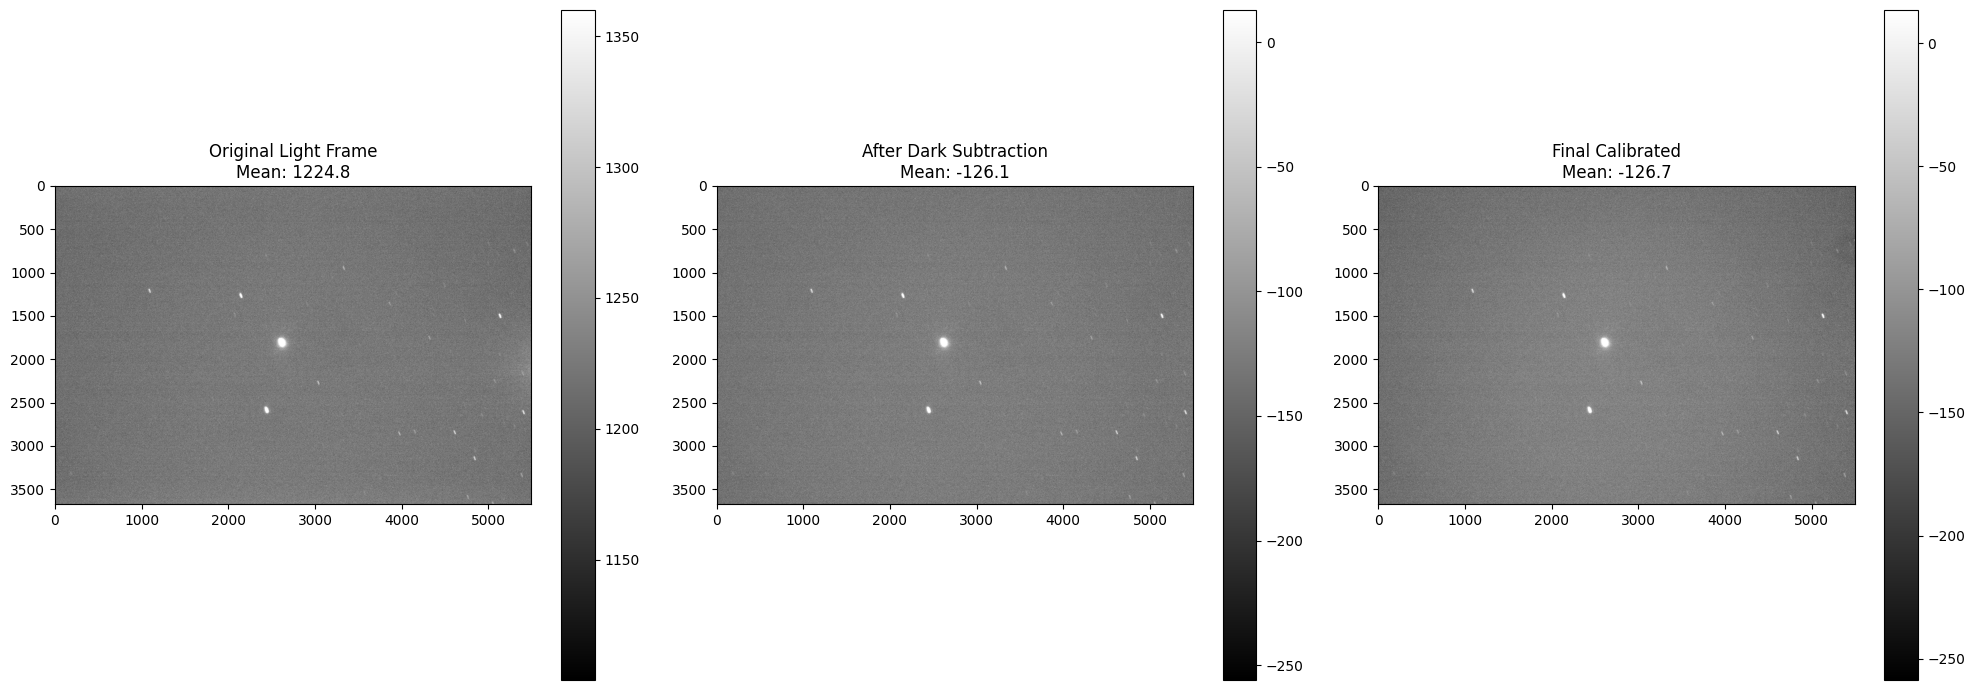

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Original
im0 = axes[0].imshow(light_data, cmap='gray', 
                      vmin=np.percentile(light_data, 1), 
                      vmax=np.percentile(light_data, 99))
axes[0].set_title(f'Original Light Frame\nMean: {np.mean(light_data):.1f}')
plt.colorbar(im0, ax=axes[0])

# After dark subtraction
im1 = axes[1].imshow(step1, cmap='gray',
                      vmin=np.percentile(step1, 1), 
                      vmax=np.percentile(step1, 99))
axes[1].set_title(f'After Dark Subtraction\nMean: {np.mean(step1):.1f}')
plt.colorbar(im1, ax=axes[1])

# Final calibrated
im2 = axes[2].imshow(calibrated, cmap='gray',
                      vmin=np.percentile(calibrated, 1), 
                      vmax=np.percentile(calibrated, 99))
axes[2].set_title(f'Final Calibrated\nMean: {np.mean(calibrated):.1f}')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()